In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
file_list = drive.ListFile({'q': "'1pbLvjcsi6UtFm3sPciCJGbCG4NK3uyuS' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Apply Naive Bayes to Amazon reviews [M].ipynb, id: 1qPxAZeYQUM-eqaKnOSM5ubK2IPIVmdyo
title: clean_final.sqlite, id: 1T0HyUqaVFyD8HfIQEM6WN8jF8SpEOsAo
title: KNN on Credit Card fraud detection.ipynb, id: 1CkA-RBfXqvubKkQrpnjbYUKVsC7VHlTl
title: creditcard.csv, id: 1VpeqlS0lPVrlzlMIqvQTzc3Pno_Cj4SV
title: creditcard.csv, id: 1bnZktEq3N_5wjoCH85oIXHxNwXUW_jx-
title: Untitled, id: 1K0wwkizWx3WO8d-zw-YewWIUrPdINYmp
title: final.sqlite, id: 1OzLc3k6-T55I-XRMq47ERyCbQbVw4caF
title: HeavyComputations.ipynb, id: 1aBORe3gqeFY-iNhzMtr-TIkzEyEvFxcG


In [0]:
sql = drive.CreateFile({'id': '1OzLc3k6-T55I-XRMq47ERyCbQbVw4caF'})
sql.GetContentFile('final.sqlite')

In [0]:
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [0]:
con = sqlite3.connect('final.sqlite') # this is cleaned dataset
final = pd.read_sql_query("""
SELECT Score, Text_not_included
FROM reviews
""", con)

In [65]:
len(final)

23953

In [0]:
for i, seq in enumerate(final['Text_not_included']):
  final['Text_not_included'][i]=final['Text_not_included'][i].decode('UTF-8')

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train , y_test = train_test_split(final['Text_not_included'], final['Score'], test_size=0.2, shuffle=False)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

In [80]:
type(y_train)

pandas.core.series.Series

In [12]:
!pip install imblearn

    100% |████████████████████████████████| 153kB 7.2MB/s 


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [100]:
bbow = CountVectorizer(ngram_range = (1,2))
bbow.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
text_vectors = bbow.transform(X_train)

In [0]:
# Oversampling train set
import imblearn
over_sampler=imblearn.over_sampling.SMOTE(ratio='minority')
X_train_resampled, y_train_resampled = over_sampler.fit_sample(text_vectors, y_train)

In [103]:
X_train_resampled.get_shape()[0]==y_train_resampled.shape[0]

True

In [104]:
len(y_train_resampled[np.where(y_train_resampled=='positive')])==len(y_train_resampled[np.where(y_train_resampled=='negative')])

True

In [105]:
X_train_resampled.getrow(5).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [0]:
text_vectors_val=bbow.transform(X_val)

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

max accuracy 0.8714255896472552 at alpha = 2


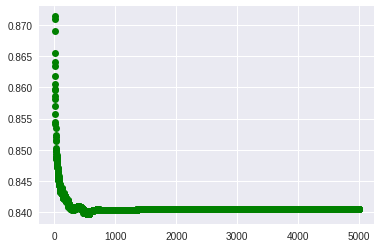

In [114]:
x=[]
y=[]
for alpha in range(1,5001,1):
  nb_clf = BernoulliNB(alpha=alpha, class_prior=[1,1])
  nb_clf.fit(X_train_resampled, y_train_resampled)
  predictions = nb_clf.predict(text_vectors_val)
  accuracy = accuracy_score(y_val, predictions)
  x.append(alpha)
  y.append(accuracy)

plt.plot(x, y, 'go')
print('max accuracy {} at alpha = {}'.format(np.max(y), x[np.argmax(y)]))

In [115]:
print('max accuracy {} at alpha = {}'.format(np.max(y), x[np.argmax(y)]))

max accuracy 0.8714255896472552 at alpha = 2


In [0]:
test_vectors=bbow.transform(X_test)

In [0]:
nb_clf = BernoulliNB(alpha=2, class_prior=[1,1])
nb_clf.fit(X_train_resampled, y_train_resampled)
predictions = nb_clf.predict(test_vectors)
accuracy = accuracy_score(y_test, predictions)

In [118]:
accuracy

0.8668336464203715

In [119]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

   negative       0.71      0.22      0.34       733
   positive       0.88      0.98      0.93      4058

avg / total       0.85      0.87      0.84      4791



In [120]:
print(confusion_matrix(y_test, predictions).T)

[[ 163   68]
 [ 570 3990]]


In [135]:
nb_clf.classes_

array(['negative', 'positive'], dtype='<U8')

In [134]:
X_train_resampled.shape

(23972, 303207)

In [138]:
len(nb_clf.feature_count_[0])

303207

In [0]:
p_wi_given_y_negative = np.array(np.reshape(nb_clf.feature_log_prob_[0], [-1]))

In [0]:
p_wi_given_y_positive = np.array(np.reshape(nb_clf.feature_log_prob_[1], [-1]))

In [0]:
feat_indices_negative=np.argsort(-p_wi_given_y_negative)
feat_indices_positive=np.argsort(-p_wi_given_y_positive)

In [154]:
type(bbow.get_feature_names())

list

In [0]:
important_features_negative = np.array(bbow.get_feature_names())[feat_indices_negative]
important_features_positive = np.array(bbow.get_feature_names())[feat_indices_positive]

In [164]:
important_features_negative[0:100]

array(['not', 'like', 'product', 'tast', 'would', 'buy', 'tri', 'get',
       'one', 'price', 'good', 'flavor', 'dont', 'use', 'review', 'way',
       'purchas', 'made', 'food', 'even', 'store', 'great', 'time',
       'order', 'eat', 'dog', 'box', 'make', 'would not', 'much',
       'bought', 'look', 'love', 'bag', 'think', 'amazon', 'first',
       'realli', 'disappoint', 'could', 'better', 'also', 'didnt',
       'foster', 'price foster', 'smith', 'foster smith', 'want', 'say',
       'bad', 'littl', 'chip', 'okay', 'packag', 'know', 'give', 'well',
       'expens', 'thought', 'got', 'never', 'differ', 'found', 'brand',
       'thing', 'someth', 'not way', 'two', 'okay would', 'way buy',
       'treat', 'ive', 'local', 'howev', 'away', 'quit', 'find', 'day',
       'money', 'open', 'still', 'receiv', 'back', 'tast like', 'ingredi',
       'recommend', 'year', 'sugar', 'product made', 'item', 'drink',
       'old', 'mix', 'mani', 'great review', 'enjoy', 'contain',
       'review pro

In [165]:
important_features_positive[0:100]

array(['not', 'like', 'love', 'good', 'tast', 'great', 'flavor', 'one',
       'tri', 'use', 'product', 'get', 'make', 'food', 'buy', 'would',
       'time', 'eat', 'best', 'realli', 'amazon', 'also', 'much', 'find',
       'price', 'dont', 'well', 'littl', 'recommend', 'order', 'store',
       'dog', 'even', 'better', 'ive', 'year', 'bag', 'high', 'tea',
       'day', 'give', 'mix', 'treat', 'sweet', 'look', 'first', 'want',
       'found', 'favorit', 'chip', 'enjoy', 'drink', 'delici', 'think',
       'way', 'keep', 'work', 'thing', 'bit', 'brand', 'need', 'made',
       'lot', 'sinc', 'nice', 'know', 'sugar', 'purchas', 'pack',
       'bought', 'coffe', 'come', 'snack', 'say', 'could', 'perfect',
       'still', 'two', 'packag', 'add', 'everi', 'mani', 'alway',
       'without', 'never', 'healthi', 'differ', 'cant', 'take', 'seem',
       'local', 'box', 'easi', 'wonder', 'ever', 'water', 'right', 'got',
       'put', 'fresh'], dtype='<U33')

## Results

Optimal alpha = 2<br><br>
Top 100 features found most commonly in negative and positive reviews are enumerated above<br><br>
Accuracy on test set = 86.68%<br>
TPR (recall wrt positive class) = 98%<br>
TNR (recall wrt negative class)= 22%<br>
FPR = 78%<br>
FNR = 2%<br>
Precision wrt positive class = 0.88<br>
Precision wrt negative class = 0.71<br>
F1 score wrt positive class = 0.93<br>
F1 score wrt negative class = 0.34<br>
<br>



### Conclusion
Even after resampling of minority class using SMOTE we observe that Naive Bayes classifier fails miserably in distinguishing negative class from positive class. The ill effects of majority class (positive reviews) dominance are clearly visible in TNR above. More than 50% of negative reviews are being classified as positive.<br>
This clearly shows that the 'naive' approximation although giving satifactory results in spam filters, is failing in this case and hence this classifier is not appropriate for text classifications in general.